# PainAttnNet Implementation for EEG Classification

In [82]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split  
import numpy as np   
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

from torchsummary import summary

from torch.optim.lr_scheduler import ReduceLROnPlateau

#transformer
import torch.nn.functional as F
import copy
from copy import deepcopy

from math import sqrt

# torch.manual_seed(0)
# np.random.seed(0)


print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Numpy version: {np.__version__}")

PyTorch version: 2.5.1
Torchvision version: 0.20.1
Numpy version: 1.26.4


---
## Data Import and Formatting for Training

In [83]:
def noise_mask(X, masking_ratio, lm=3, mode='separate', distribution='geometric', exclude_feats=None):
    """
    Creates a random boolean mask of the same shape as X, with 0s at places where a feature should be masked.
    Args:
        X: (batch_size, seq_length, feat_dim) tensor of features corresponding to a batch of samples
        masking_ratio: proportion of seq_length to be masked. At each time step, will also be the proportion of
            feat_dim that will be masked on average
        lm: average length of masking subsequences (streaks of 0s). Used only when `distribution` is 'geometric'.
        mode: whether each variable should be masked separately ('separate'), or all variables at certain positions
            should be masked concurrently ('concurrent')
        distribution: whether each mask sequence element is sampled independently at random, or whether
            sampling follows a markov chain (and thus is stateful), resulting in geometric distributions of
            masked sequences of a desired mean length `lm`
        exclude_feats: iterable of indices corresponding to features to be excluded from masking (i.e. to remain all 1s)

    Returns:
        boolean tensor with the same shape as X, with 0s at places where a feature should be masked
    """
    if isinstance(X, np.ndarray):
        X = torch.tensor(X)  # Convert NumPy array to PyTorch tensor
    seq_length = X.shape[0] 
    mask = torch.ones_like(X, dtype=torch.bool)

    if exclude_feats is not None:
        exclude_feats = set(exclude_feats)

    if distribution == 'geometric':  # stateful (Markov chain)
        if mode == 'separate':  # each variable (feature) is independent
            mask = geom_noise_mask_single(seq_length, lm, masking_ratio)  # time dimension
        else:  # replicate across feature dimension (mask all variables at the same positions concurrently)
            mask_single = geom_noise_mask_single(seq_length, lm, masking_ratio).numpy()
            mask[b] = torch.from_numpy(mask_single)
    else:  # each position is independent Bernoulli with p = 1 - masking_ratio
        if mode == 'separate':
            mask = torch.from_numpy((torch.rand_like(X, dtype=torch.float) > masking_ratio).numpy())
        else:
            mask_single = (torch.rand((seq_length), dtype=torch.float) > masking_ratio).numpy()
            mask = torch.from_numpy(mask_single)

    return mask


def geom_noise_mask_single(L, lm, masking_ratio):
    """
    Randomly create a boolean mask of length `L`, consisting of subsequences of average length lm, masking with 0s a `masking_ratio`
    proportion of the sequence L. The length of masking subsequences and intervals follow a geometric distribution.
    Args:
        L: length of mask and sequence to be masked
        lm: average length of masking subsequences (streaks of 0s)
        masking_ratio: proportion of L to be masked

    Returns:
        (L,) boolean tensor intended to mask ('drop') with 0s a sequence of length L
    """
    keep_mask = torch.ones(L, dtype=torch.bool)
    p_m = 1 / lm  # probability of each masking sequence stopping. parameter of geometric distribution.
    p_u = p_m * masking_ratio / (1 - masking_ratio)  # probability of each unmasked sequence stopping. parameter of geometric distribution.
    p = [p_m, p_u]

    # Start in state 0 with masking_ratio probability
    state = int(torch.rand(1).item() > masking_ratio)  # state 0 means masking, 1 means not masking
    for i in range(L):
        keep_mask[i] = state  # here it happens that state and masking value corresponding to state are identical
        if torch.rand(1).item() < p[state]:
            state = 1 - state

    return keep_mask

In [84]:

# Traitement des données

from sklearn.preprocessing import StandardScaler

#load data from data.pkl in a tensor
with open('data.pkl', 'rb') as file: #récupération des données
    data = pickle.load(file)

#filtrage des signaux EEG
# Définir les fréquences de coupure et de la fréquence d'échantillonnage du signal
low_cutoff = 0.53
high_cutoff = 40
sample_rate = 173.61

# Conception du filtre passe-bande
nyquist = 0.5 * sample_rate
low = low_cutoff / nyquist
high = high_cutoff / nyquist
b, a = butter(4, [low, high], btype='band')

# Séparer les labels des données
labels = data[:, 0]  # La première colonne correspond aux labels
signals = data[:, 1:]  # Les colonnes restantes sont les données à filtrer

# Appliquer le filtre passe-bande aux données
filtered_signals = filtfilt(b, a, signals, axis=1)

# Faire une copie des signaux filtrés pour éviter les strides négatifs (c'est à dire pour que les données soient stockées de manière contiguë en mémoire)
filtered_signals = filtered_signals.copy()

# Normalize signals to [-1,1] range
def normalize_minmax(signals):
    #Soustraction de la moyenne
    mean = signals.mean(axis=1, keepdims=True)
    signals = signals - mean

    # Division par l'écart-type (variance)  
    std = signals.std(axis=1, keepdims=True)  
    std[std == 0] = 1e-8  # Éviter la division par zéro  
    normalized = signals / std  

    # # Get min and max per signal
    # signal_min = np.min(normalized, axis=1, keepdims=True)
    # signal_max = np.max(normalized, axis=1, keepdims=True)
    
    # # Avoid division by zero
    # denominator = signal_max - signal_min
    # denominator[denominator == 0] = 1e-8
    
    # # Scale to [-1,1]
    # normalized = 2 * ((signals - signal_min) / denominator) - 1
    
    return normalized

# # Normalisation des signaux
# mean = filtered_signals.mean(axis=1, keepdims=True)
# variance = filtered_signals.var(axis=1, keepdims=True)
# filtered_signals = (filtered_signals - mean) / np.sqrt(variance)

filtered_signals = normalize_minmax(filtered_signals)

# Créer un Dataset personnalisé
class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, signals, labels):
        self.signals = torch.tensor(signals, dtype=torch.float32).unsqueeze(1)  # Ajouter une dimension pour le canal
        self.labels = torch.tensor(labels, dtype=torch.long)
        #Modification labels sain et malade
        for idx in range(len(self.labels)):
            match labels[idx]:
                case 1: #A
                    self.labels[idx]=0
                case 2: #B
                    self.labels[idx]=1
                case 3: #C
                    self.labels[idx]=2
                case 4: #D
                    self.labels[idx]=3
                case 5: #E
                    self.labels[idx]=4

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        return self.signals[idx], self.labels[idx]
    
    def __getlabel__(self, idx):
        return self.labels[idx]

# Ajout de la classe dataset avec masquage
class EEGImputationDataset(torch.utils.data.Dataset):
    def __init__(self, signals, labels, mean_mask_length, masking_ratio,
                 mode='separate', distribution='geometric'):
        self.signals = signals
        self.labels = labels
        self.masking_ratio = masking_ratio
        self.mean_mask_length = mean_mask_length
        self.mode = mode 
        self.distribution = distribution

    def __getitem__(self, idx):
        # Récupérer le signal et le label
        x = self.signals[idx]
        label = self.labels[idx] if self.labels is not None else None
        
        # Convertir en tensor si nécessaire
        if not torch.is_tensor(x):
            x = torch.tensor(x, dtype=torch.float32)
        
        # Créer une copie du signal original
        x_original = x.clone()
        
        # Générer le masque de bruit
        mask = noise_mask(x,
                        masking_ratio=self.masking_ratio,
                        lm=self.mean_mask_length,
                        mode=self.mode,
                        distribution=self.distribution)
        
        # S'assurer que le masque est un tensor
        mask = mask.float()
        
        # Appliquer le masque au signal
        x_masked = x * mask
        
        # Ajouter une dimension pour le canal si nécessaire
        x_masked = x_masked.unsqueeze(0) if len(x_masked.shape) == 1 else x_masked
        mask = mask.unsqueeze(0) if len(mask.shape) == 1 else mask
        x_original = x_original.unsqueeze(0) if len(x_original.shape) == 1 else x_original
        
        if label is not None:
            label = torch.tensor(label)
        
        return x_masked, mask, x_original, label

    def __len__(self):
        return len(self.signals)

# Créer un dataset personnalisé avec masquage
dataset = EEGImputationDataset(
    signals=filtered_signals, 
    labels=labels,
    mean_mask_length=3,
    masking_ratio=0.2,
    mode='separate'
)

## Comparaison visuelle du signal filtré et original

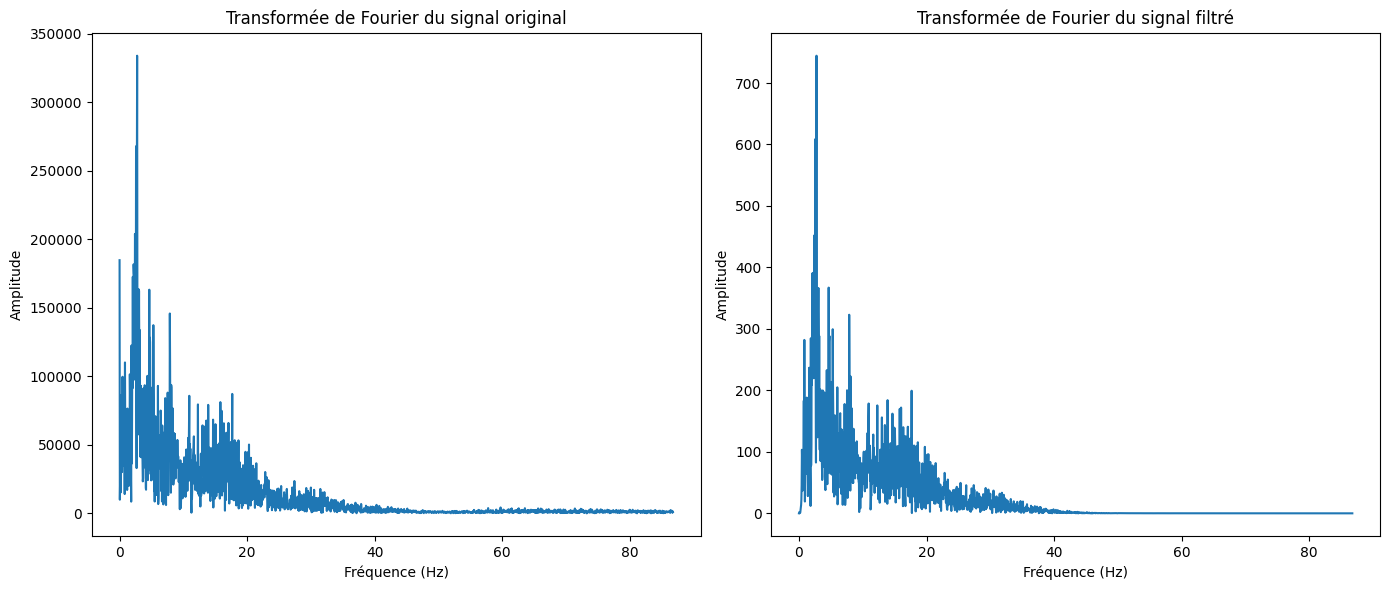

In [85]:
#Transformée de Fourier d'un des signaux filtrés et de sa version originale

# Sélectionner un signal aléatoire
random_index = np.random.randint(0, data.shape[0])
original_signal = data[random_index]
filtered_signal = filtered_signals[random_index]

# Calculer la transformée de Fourier
original_fft = np.fft.fft(original_signal)
filtered_fft = np.fft.fft(filtered_signal)

# Calculer les fréquences correspondantes
freqs = np.fft.fftfreq(len(original_signal), d=1/sample_rate)

# Ajuster les longueurs pour correspondre
half_n = len(original_signal) // 2
freqs = freqs[:half_n]
original_fft = original_fft[:half_n]
filtered_fft = filtered_fft[:half_n]

# Afficher les résultats
plt.figure(figsize=(14, 6))

# Transformée de Fourier du signal original
plt.subplot(1, 2, 1)
plt.plot(freqs, np.abs(original_fft))
plt.title('Transformée de Fourier du signal original')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')

# Transformée de Fourier du signal filtré
plt.subplot(1, 2, 2)
plt.plot(freqs, np.abs(filtered_fft))
plt.title('Transformée de Fourier du signal filtré')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

## Diviser les données en ensembles d'entraînement, de validation et de test

In [86]:
# Calculate sizes for split
train_size = int(0.8 * 100)  # 80 samples per class with 100 the size of each set
val_size = int(0.2 * 100)    # 10 samples per class
test_size = 100 - train_size - val_size  # Remaining samples per class

# Initialize empty lists for each split
train_data_list = []
val_data_list = []
test_data_list = []

# Split each class separately and combine
for set_start in range(0, len(dataset), 100):  # Each set has 100 samples
    set_data = torch.utils.data.Subset(dataset, range(set_start, set_start + 100))
    class_splits = random_split(set_data, [train_size, val_size, test_size])
    train_data_list.append(class_splits[0])
    val_data_list.append(class_splits[1])
    test_data_list.append(class_splits[2])

# Combine the splits using ConcatDataset
train_data = torch.utils.data.ConcatDataset(train_data_list)
val_data = torch.utils.data.ConcatDataset(val_data_list)
test_data = torch.utils.data.ConcatDataset(test_data_list)

# Create DataLoaders
batch_size = 1  # taille du batch
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print("Ensemble d'entraînement :", len(train_data))  
print("Ensemble de validation :", len(val_data))  
print("Ensemble de test :", len(test_data))

Ensemble d'entraînement : 400
Ensemble de validation : 100
Ensemble de test : 0


## Visualize a Batch of Training Data

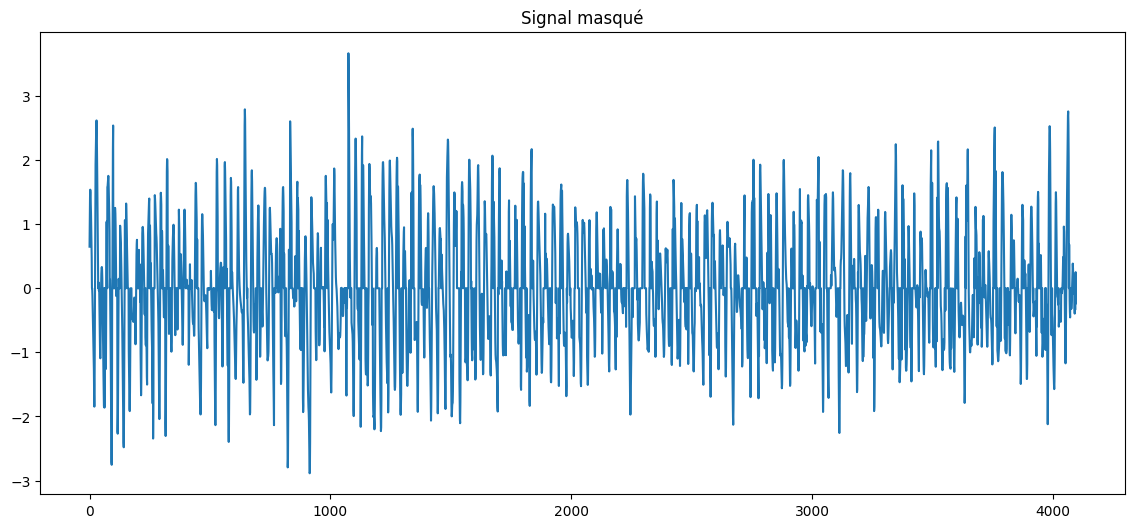

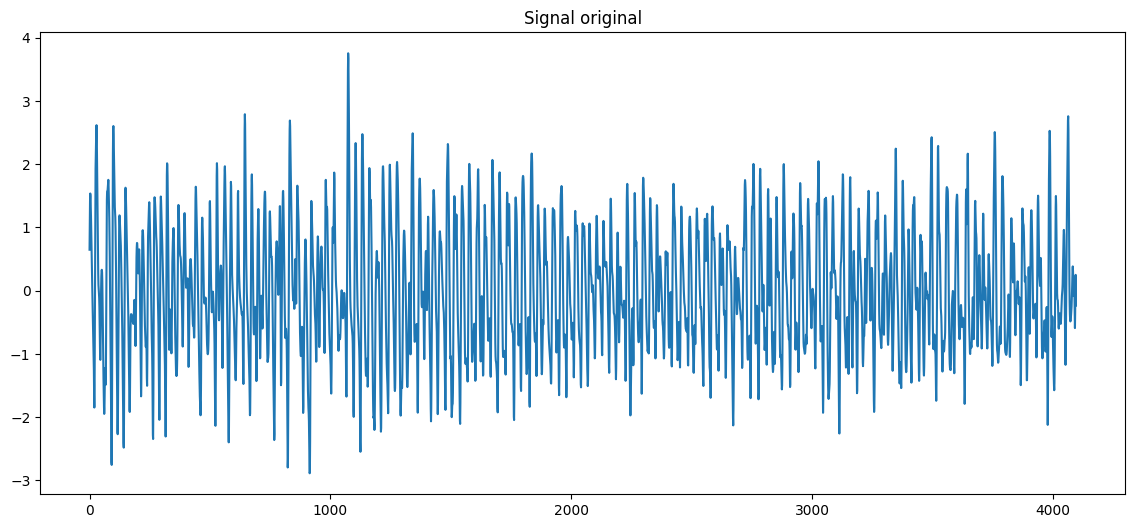

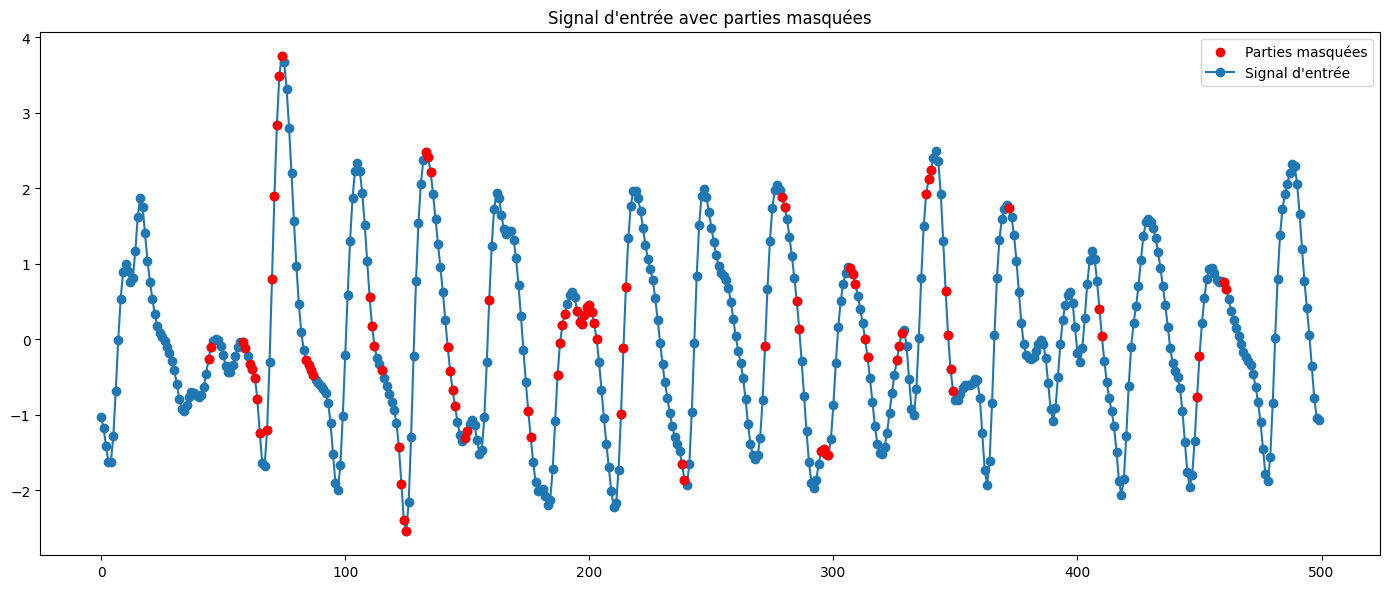

Rapport de 0 par rapport au reste : [0.19038321]
Moyenne des ratios de 0 0.19038320722479862


In [87]:
# Sélectionner un batch aléatoire de signaux d'entraînement
dataiter = iter(train_loader)
x_masked, mask, x, labels = next(dataiter)

#Comparaison x_masked et x pour 1 signal
# Sélectionner un signal aléatoire
random_index = np.random.randint(0, x_masked.shape[0])
signal = x_masked[random_index].squeeze().cpu().numpy()
original_signal = x[random_index].squeeze().cpu().numpy()
#Affichage des signaux sur 2 graphiques différents
plt.figure(figsize=(14, 6))
plt.plot(signal.T)
plt.title("Signal masqué")
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(original_signal.T)
plt.title("Signal original")
plt.show()



# # Afficher les signaux dans le batch, avec les labels correspondants
# plt.figure(figsize=(14, 6))
# for i in range(10):
#     plt.subplot(2, 5, i + 1)
#     plt.plot(x_masked[i].squeeze().cpu().numpy().T)
#     plt.title(f"Label : {labels[i].item()}")
#     plt.axis('off')
# plt.tight_layout()
# plt.show()

# Afficher un signal d'entrée au hasard et sa reconstruction
random_index = np.random.randint(0, x.shape[0])
input_signal = x[random_index].squeeze().cpu().numpy()
mask_signal = mask[random_index].cpu().numpy().squeeze()

plt.figure(figsize=(14, 6))

# Afficher les parties masquées en rouge
masked_indices = np.where(mask_signal[1000:1500] == 0)[0]
plt.scatter(masked_indices, input_signal[masked_indices + 1000], color='red', label='Parties masquées', zorder=3)

# Afficher le signal d'entrée et le signal reconstruit sur le même graphique
plt.plot(input_signal[1000:1500], marker='o', label='Signal d\'entrée', zorder=1)
plt.title("Signal d'entrée avec parties masquées")
plt.legend()

plt.tight_layout()
plt.show()

# Afficher le rapport du nombre de 0 par rapport aux reste sur les signaux masqués
# Calculer le nombre de 0 dans chaque signal masqué
num_zeros = (x_masked == 0).sum(dim=2).sum(dim=1).cpu().numpy()
# Calculer le nombre total de valeurs dans chaque signal
num_total = x_masked.shape[2]
# Calculer le rapport de 0 par rapport au reste
zero_ratio = num_zeros / num_total
print("Rapport de 0 par rapport au reste :", zero_ratio)
#affichage de la moyenne des ratios
print("Moyenne des ratios de 0", zero_ratio.mean())


---
## Define the Network Architecture

### Define the Models

In [88]:
# Model MSCN (Multi-Scale Convolutional Network)
class MSCN(nn.Module):
    def __init__(self,mscn_output_channels,model_dim,kernel_size_short,kernel_size_medium,kernel_size_long,stride_short,stride_medium,stride_long):
        super().__init__()
        dropout = 0.5

        self.short_scale = nn.Sequential(
            nn.Conv1d(1, mscn_output_channels, kernel_size_short, stride_short, dilation=1, bias=False, padding=9), #anciennement kernel_size=50, stride=6, padding=24 
            nn.BatchNorm1d(mscn_output_channels), 
            nn.GELU(),
            nn.MaxPool1d(kernel_size=8, stride=2, padding=4),
            nn.Dropout(dropout),

            nn.Conv1d(mscn_output_channels, 128, kernel_size=8, stride=1, bias=False, padding=4),
            nn.BatchNorm1d(128),
            nn.GELU(),

            nn.Conv1d(128, mscn_output_channels, kernel_size=8, stride=1, bias=False, padding=4),
            nn.BatchNorm1d(mscn_output_channels),
            nn.GELU(),

            nn.MaxPool1d(kernel_size=4, stride=4, padding=2)
        )

        self.medium_scale = nn.Sequential(
            nn.Conv1d(1, mscn_output_channels, kernel_size_medium, stride_medium, dilation=1, bias=False, padding=38), #anciennement kernel_size=512, stride=42, padding=256
            nn.BatchNorm1d(mscn_output_channels),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=4, stride=4, padding=0),
            nn.Dropout(dropout),

            nn.Conv1d(mscn_output_channels, 128, kernel_size=4, stride=1, bias=False, padding=3),
            nn.BatchNorm1d(128),
            nn.GELU(),

            nn.Conv1d(128, mscn_output_channels, kernel_size=4, stride=1, bias=False, padding=3),
            nn.BatchNorm1d(mscn_output_channels),
            nn.GELU(),

            nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        )

        self.long_scale = nn.Sequential(
            nn.Conv1d(1, mscn_output_channels, kernel_size_long, stride_long, dilation=1, bias=False, padding=67), #anciennement kernel_size=1024, stride=84, padding=512
            nn.BatchNorm1d(mscn_output_channels),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=8, stride=8, padding=0),
            nn.Dropout(dropout),

            nn.Conv1d(mscn_output_channels, 128, kernel_size=8, stride=1, bias=False, padding=3),
            nn.BatchNorm1d(128),
            nn.GELU(),

            nn.Conv1d(128, mscn_output_channels, kernel_size=8, stride=1, bias=False, padding=3),
            nn.BatchNorm1d(mscn_output_channels),
            nn.GELU(),

            nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        )
        x_short_test=self.short_scale(torch.randn(1, 1, 4097))
        x_medium_test=self.medium_scale(torch.randn(1, 1, 4097))
        x_long_test=self.long_scale(torch.randn(1, 1, 4097))
                    
        self.dropout = nn.Dropout(dropout)
        self.fc_short = nn.Linear(x_short_test.shape[2], model_dim)
        self.fc_medium = nn.Linear(x_medium_test.shape[2], model_dim)
        self.fc_long = nn.Linear(x_long_test.shape[2], model_dim)
      

    def forward(self, x):
        x_short1 = self.short_scale(x)
        # print(x_short.shape[2]) # (128, 64, 60) for BioVid
        x_medium1 = self.medium_scale(x)
        # print(x_medium.shape[2]) # (128, 64, 12) for BioVid
        x_long1 = self.long_scale(x)
        # print(x_long.shape[2]) # (128, 64, 3) for BioVid

        x_short2 = self.fc_short(x_short1)
        x_medium2 = self.fc_medium(x_medium1)
        x_long2 = self.fc_long(x_long1)

        x_concat = torch.cat((x_short2, x_medium2, x_long2), dim=1)

        x_concat = self.dropout(x_concat)

        return x_concat, x_short1, x_medium1, x_long1
        
        # Short scale output calculation:
        # Input: 4097
        # Conv1d: (4097 + 2*9 - 18)/2 + 1 = 2049
        # MaxPool1d: (2049 + 2*4 - 8)/2 + 1 = 1025
        # Conv1d: 1025 + 2*4 - 8 + 1 = 1026
        # Conv1d: 1026 + 2*4 - 8 + 1 = 1027
        # MaxPool1d: (1027 + 2*2 - 4)/4 + 1 = 257

        # Medium scale output calculation:
        # Input: 4097
        # Conv1d: (4097 + 2*38 - 76)/10 + 1 = 410
        # MaxPool1d: (410 - 4)/4 + 1 = 102
        # Conv1d: 102 + 2*3 - 4 + 1 = 105
        # Conv1d: 105 + 2*3 - 4 + 1 = 108
        # MaxPool1d: (108 + 2*1 - 2)/2 + 1 = 55

        # Long scale output calculation:
        # Input: 4097
        # Conv1d: (4097 + 2*67 - 134)/17 + 1 = 242
        # MaxPool1d: (242 - 8)/8 + 1 = 30
        # Conv1d: 30 + 2*3 - 7 + 1 = 30
        # Conv1d: 30 + 2*3 - 7 + 1 = 30
        # MaxPool1d: (30 + 2*1 - 2)/2 + 1 = 16


In [89]:
# Model SEResNet (Residual network with squeeze-and-excitation blocks)

"""
This module contains the implementation of the SEResNet architecture.
"""

# First, we define the Squeeze-and-Excitation block.
class SENet(nn.Module):
    """
    Squeeze-and-Excitation block for channel-wise attention.
    """

    # First, the input is averaged using an adaptive average pooling layer to create a single value per channel.
    # Then, two fully connected layers are used to create the attention weights.
    # Finally, the input is multiplied by the attention weights to create the output.
    def __init__(self, channel, reduction=16): 
        super(SENet, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential( # Create the fully connected layers
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x) # Multiply the input by the attention weights


# Second, we define the building block which prepares the input before sending it to the SE block and adds the 
# global input to the output of the SE block.
class SEBasicBlock(nn.Module):
    """
    Basic building block for squeeze-and-excitation networks with other layers.
    """
    expansion = 1

    # The block consists of two convolutional layers with batch normalization and ReLU activation functions.
    def __init__(self, input_channels, output_channels, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None,
                 *, reduction=16):
        super(SEBasicBlock, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, output_channels, stride)
        self.bn1 = nn.BatchNorm1d(output_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(output_channels, output_channels, 1)
        self.bn2 = nn.BatchNorm1d(output_channels)
        self.se = SENet(output_channels, reduction) # Send the output in the SE block
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        # First convolutional layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Second convolutional layer
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)

        # Downsample if necessary
        if self.downsample is not None:
            residual = self.downsample(x)

        # Add residual connection and apply ReLU
        out += residual
        out = self.relu(out)

        return out


# Finaly, we create the ResNet architecture with 'blocks_size' number of SEBasicBlock instances put end-to-end.
class SEResNet(nn.Module):
    """
    Residual network with squeeze-and-excitation blocks

    Downsampling is performed by conv1 when stride != 1 or
    the input_channels size is not equal to the output size.
    """
    def __init__(self, output_channels, block_size, mscn_output_channels_times3):
        super(SEResNet, self).__init__()
        self.input_channels = mscn_output_channels_times3 # Number of feature maps in the input
        self.block = SEBasicBlock 
        self.layer = self._make_layer(self.block, output_channels, block_size)

    # Create a layer with 'blocks' number of SEBasicBlock instances.
    def _make_layer(self, block, output_channels, blocks, stride = 1):
        downsample = self._downsample_layer(self.input_channels, output_channels * block.expansion, stride) # Downsample if necessary

        layers = [block(self.input_channels, output_channels, stride, downsample)] # Create the first block with downsample if necessary
        self.input_channels = output_channels * block.expansion # Update the number of feature maps depending on the block expansion
        layers.extend(block(self.input_channels, output_channels) for _ in range(1, blocks)) # Create the rest of the blocks

        return nn.Sequential(*layers)

    @staticmethod
    def _downsample_layer(input_channels, output_channels, stride):
        if stride != 1 or input_channels != output_channels:
            return nn.Sequential(
                nn.Conv1d(input_channels, output_channels,
                          kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm1d(output_channels)
            )
        return None

    def forward(self, x):
        return self.layer(x)

In [90]:
# Model TransformerEncoder (Transformer Encoder)

#la classe encoderwrapper englobe tout:
#elle appelle multiple couche de "transformerencoder", transformerencoder qui prend en entrée un multiheadattention et un mlp
#le sublayer output prend ensuite en entrée les multiheadattention et mlp et applique le modèle
#donc: encoderwrapper --> transformerencoder --> sublayeroutput --> convolution, multiheadattention, mlp et ce multiple fois

# Utility function
def clones(module, N): 
    """
    Generate N identical layers

    Args:
        module (nn.Module): PyTorch module to be cloned
        N (int): Number of clones to create

    Returns:
        nn.ModuleList: List of N cloned PyTorch modules
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class TCN(nn.Module):
    """
    Temporal Convolutional Network with causal padding, residual connections, and batch normalization

    When kernel_size equals to zero, the padding is not causal
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, causal=True):
        super(TCN, self).__init__()
        padding = (kernel_size - 1) * dilation if causal else 0
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, dilation)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding, dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.causal = causal
        self.tcn_padding = padding
        self.downsample = None

        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, 1),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))

        if self.causal:
            out = out[:, :, :-self.tcn_padding]

        out = self.bn2(self.conv2(out))

        if self.causal:
            out = out[:, :, :-self.tcn_padding]

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, model_dim, se_reduced_size, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.tcn = clones(TCN(se_reduced_size, se_reduced_size, kernel_size=7), 2)
        # If set batch_first=True, for nn.MultiheadAttention()
        # then the input and output tensors are provided as (batch, seq, feature(channels))
        self.multihead_attention = nn.MultiheadAttention(se_reduced_size, num_heads, batch_first=True,
                                                         dropout=dropout)

    def forward(self, query, key, value):
        """
        We swap the seq and channel dimensions for the input tensors to
        meet the requirements of nn.MultiheadAttention()
        e.g. BioVid, (batch_size=128, seq_len=75, out_channels=30)
        :return: dimension (batch_size, out_channels, seq_len)
        """
        query = query.transpose(1, 2)
        key = self.tcn[0](key).transpose(1, 2)
        value = self.tcn[1](value).transpose(1, 2)
        attn_output, attn_output_weights = self.multihead_attention(query, key, value)
        # Swap back to the original dimensions
        attn_output = attn_output.transpose(1, 2)
        return attn_output

class MLP(nn.Module):
    """
    Multi-Layer Perceptron
    """
    def __init__(self, model_dim, d_mlp, dropout=0.1):
        super(MLP, self).__init__()
        self.w_1 = nn.Linear(model_dim, d_mlp)
        self.w_2 = nn.Linear(d_mlp, model_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        MLP forward pass
        """
        return self.w_2(self.dropout(F.relu(self.w_1(x))))


class LayerNorm(nn.Module):
    """
    Layer Normalization
    """
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


class SublayerOutput(nn.Module):
    """
    Residual connection followed by a layer norm.
    """
    def __init__(self, se_reduced_size, dropout):
        super(SublayerOutput, self).__init__()
        self.norm = nn.LayerNorm(se_reduced_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        """
        Apply residual connection to any sublayer with the same size.
        """
        normalized_x = self.norm(x.transpose(1, 2)).transpose(1, 2)
        return x + self.dropout(sublayer(normalized_x)) 


class TransformerEncoder(nn.Module):
    """
    Transformer Encoder

    Integration of MHA and MLP.
    Each of these sublayers have residual and layer norm, implemented by SublayerOutput.
    """
    def __init__(self, model_dim, self_attn, feed_forward, se_reduced_size, dropout):
        super(TransformerEncoder, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer_output = clones(SublayerOutput(se_reduced_size, dropout), 2)
        self.size = model_dim
        self.conv = TCN(se_reduced_size, se_reduced_size, kernel_size=7)

    def forward(self, x_in):
        query = self.conv(x_in)
        # Encoder self-attention
        x = self.sublayer_output[0](query, lambda x: self.self_attn(query, x_in, x_in))
        return self.sublayer_output[1](x, self.feed_forward)


class EncoderWrapper(nn.Module):
    """
    Transformer Encoder Wrapper

    It is a stack of N layers of transformer encoder, default N=2.
    """
    def __init__(self, num_heads, model_dim, se_reduced_size, d_mlp, dropout, N):
        super(EncoderWrapper, self).__init__()
        attn = MultiHeadAttention(num_heads, model_dim, se_reduced_size)

        mlp = MLP(model_dim, d_mlp, dropout)
        layer = TransformerEncoder(model_dim, deepcopy(attn), deepcopy(mlp), se_reduced_size, dropout)

        self.layers = clones(layer, N)
        self.norm = nn.LayerNorm(layer.size)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)



In [91]:
# Model LatentDecoder (Latent Decoder)

class LatentDecoder(nn.Module):        
    def __init__(self, num_heads, model_dim, senet_reduced_size, d_mlp, dropout, N):
        super(LatentDecoder, self).__init__()
        
        # Transformer Encoder Wrapper
        self.num_heads = num_heads
        self.model_dim = model_dim  # Assuming latent_feat_dim = model_dim
        self.senet_reduced_size = senet_reduced_size
        self.d_mlp = d_mlp  # Dimension for MLP hidden layer
        self.dropout = dropout
        self.num_layers = N

        self.transformer = EncoderWrapper(
            num_heads=self.num_heads,
            model_dim=self.model_dim,
            se_reduced_size=self.senet_reduced_size,
            d_mlp=self.d_mlp,
            dropout=self.dropout,
            N=self.num_layers
        )
        
        # Convolution pour ajuster la dimension (10 -> 64)
        self.linear_projection = nn.Conv1d(10, 64, kernel_size=1)
        self.batch_norm = nn.BatchNorm1d(64)

        # Projection Layer
        # self.linear_projection = nn.Conv1d(
        #     in_channels=10,  # Dimension actuelle
        #     out_channels=64,  # Dimension cible
        #     kernel_size=1  # Pas de modification sur la dimension temporelle
        # )

        # Upsampling Layer
        self.upsampling1 = nn.Upsample(size=4096)    
    

        # Transposed Convolutions
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=5, stride=1, padding=2)
        self.deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=5, stride=1, padding=2)
        self.deconv3 = nn.ConvTranspose2d(16, 8, kernel_size=5, stride=1, padding=2)
        self.deconv4 = nn.ConvTranspose2d(8, 4, kernel_size=5, stride=1, padding=2)
        self.deconv5 = nn.ConvTranspose2d(4, 2, kernel_size=5, stride=1, padding=2)
        self.deconv6 = nn.ConvTranspose2d(2, 1, kernel_size=5, stride=1, padding=2)
        
        # Final Linear Layer for exact output size
        self.final_linear = nn.Linear(4096, 4097)  # Adjust to match 4097
    

    def forward(self, latent):

        # Transformer Encoder
        transformed = self.transformer(latent)  # Output is (batch, seq_len, features)

        #print(transformed.shape)

        
        # Appliquer la projection linéaire avec Conv1d + BatchNorm1d + ReLU
        transformed = self.linear_projection(transformed)
        transformed = F.relu(self.batch_norm(transformed))
        
        # print(transformed.shape)

        # Upsampling
        transformed = self.upsampling1(transformed)

        # print(transformed.shape)

        transformed = transformed.unsqueeze(1)  # Add channel dimension

        transformed = transformed.permute(0, 2, 1, 3)

        # print(transformed.shape)

        # Transposed Convolutions
        #print(transformed.shape)
        decoded = F.relu(self.deconv1(transformed))
        # print(decoded.shape)
        decoded = F.relu(self.deconv2(decoded))
        # print(decoded.shape)
        decoded = F.relu(self.deconv3(decoded))
        # print(decoded.shape)
        decoded = F.relu(self.deconv4(decoded)) 
        # print(decoded.shape)
        decoded = F.relu(self.deconv5(decoded)) 
        # print(decoded.shape)
        decoded = self.deconv6(decoded) # Pas de ReLU à la fin
        #print(decoded.shape)
        
        # Final Linear Layer
        decoded = decoded.squeeze(1).squeeze(1)  # Remove channel dimension
        # print(decoded.shape)
        decoded = self.final_linear(decoded)
        # print(decoded.shape)
        return decoded

In [92]:
# Decoder2 (Decoder numero 2)
class Decoder2(nn.Module):
    """
    Décode le vecteur latent et renvoie les données reconstruites
    """

    def __init__(self, model_dim, senet_reduced_size):
        super(Decoder2, self).__init__()

        self.model_dim = model_dim
        self.senet_reduced_size = senet_reduced_size

        # Couches convolutives
        self.conv1 = nn.Conv2d(senet_reduced_size, 32, kernel_size=5, stride=1, padding=2)
        self.convbatchNorm1 = nn.BatchNorm2d(32)
        self.upsampling1 = nn.Upsample(size=(1, 2048))  # (1, 16, 10, 512)
        self.ConvUp1 = nn.ConvTranspose2d(32, 16, kernel_size=1, stride=1)
        self.ConvUp2 = nn.ConvTranspose2d(16, 8, kernel_size=1, stride=1)
        self.ConvUp3 = nn.ConvTranspose2d(8, 1, kernel_size=1, stride=1)
        # Couches denses
        self.dense1 = nn.Linear(model_dim*senet_reduced_size, 512)
        self.dense2 = nn.Linear(512, 1024)
        self.dense3 = nn.Linear(1024, 2048)
        # concaténation
        self.concatDense1 = nn.Linear(4096, 4097)

    def forward(self, z):
        # Couches convolutives
        # print(z.shape)
        z_conv = z.unsqueeze(0)
        z_conv = z_conv.permute(1, 2, 0, 3)
        # print(z_conv.shape)
        z_conv = F.relu(self.convbatchNorm1(self.conv1(z_conv)))
        # print(z_conv.shape)
        z_conv = self.upsampling1(z_conv)
        # print(z_conv.shape)
        z_conv = self.ConvUp1(z_conv)
        # print(z_conv.shape)
        z_conv = self.ConvUp2(z_conv)
        # print(z_conv.shape)
        z_conv = self.ConvUp3(z_conv)
        # print(z_conv.shape)
        z_conv = z_conv.squeeze(1).squeeze(1)
        # print(z_conv.shape)
        # Couches denses
        # print("z=",z.shape)
        #concatenation de z sur les 2 dernières dimensions
        z_dense = z.view(z.shape[0],-1)
        # print(z_dense.shape)
        z_dense = F.relu(self.dense1(z_dense))
        # print(z_dense.shape)
        z_dense = F.relu(self.dense2(z_dense))
        # print(z_dense.shape)
        z_dense = F.relu(self.dense3(z_dense))
        # print(z_dense.shape)
        #z_dense = z_dense.flatten()
        # Concaténation
        # print(z_conv.shape)
        # print(z_dense.shape)
        z_dense = torch.cat((z_conv, z_dense), 1)
        # Dernières couches denses
        z_final = self.concatDense1(z_dense)
        #z_final = z_final.reshape(1, 4097)
        return z_final

In [93]:
# Residual Decoder (ResidualBlock1D)  
class ResidualBlock1D(nn.Module):  
    """  
    Un bloc résiduel générique pour les couches 1D avec upsampling.  
    """  
    def __init__(self, in_channels, out_channels, kernel_size=3, upsample_scale=None, dropout_rate=0.2):  
        super(ResidualBlock1D, self).__init__()  
        self.upsample = (  
            nn.Upsample(scale_factor=upsample_scale, mode='linear', align_corners=True)  
            if upsample_scale else None  
        )  
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)  
        self.batchnorm1 = nn.BatchNorm1d(out_channels)  
        self.relu = nn.ReLU()  
        self.dropout1 = nn.Dropout(p=dropout_rate)  # Dropout ajouté après la première activation  
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)  
        self.batchnorm2 = nn.BatchNorm1d(out_channels)  
        self.dropout2 = nn.Dropout(p=dropout_rate)  # Dropout ajouté après la deuxième activation  

    def forward(self, x):  
        if self.upsample:  
            x = self.upsample(x)  
        residual = x  
        x = self.conv1(x)  
        x = self.batchnorm1(x)  
        x = self.relu(x)  
        x = self.dropout1(x)  # Appliquer Dropout après la première activation  
        x = self.conv2(x)  
        x = self.batchnorm2(x)  
        x = self.dropout2(x)  # Appliquer Dropout après la deuxième activation  
        x = torch.cat((x, residual), dim=1)  # Connexion résiduelle  
        return x  


class SignalDecoder(nn.Module):  
    def __init__(self, previous_feat_size, model_dim, dropout_rate=0.5):  
        super(SignalDecoder, self).__init__()  

        self.feature_size = previous_feat_size  
        self.time_size = model_dim  

        # Définition des blocs résiduels avec upsampling  
        self.block1 = ResidualBlock1D(32, 32, kernel_size=3, upsample_scale=2, dropout_rate=dropout_rate)  
        self.block2 = ResidualBlock1D(64, 64, kernel_size=3, upsample_scale=2, dropout_rate=dropout_rate)  

        self.upsample1 = nn.Upsample(scale_factor=2, mode='linear', align_corners=True)  
        self.conv1 = nn.Conv1d(128, 64, kernel_size=3, padding=1)   
        self.batchnorm1 = nn.BatchNorm1d(64)  
        self.dropout1 = nn.Dropout(p=dropout_rate)  # Dropout ajouté après la première convolution  

        self.upsample2 = nn.Upsample(scale_factor=2, mode='linear', align_corners=True)  
        self.conv2 = nn.Conv1d(64, 1, kernel_size=3, padding=1)   
        self.batchnorm2 = nn.BatchNorm1d(1)  
        self.dropout2 = nn.Dropout(p=dropout_rate)  # Dropout ajouté après la deuxième convolution  

        # Convolution finale pour réduire les dimensions  
        self.final_projection = nn.Conv1d(1, 1, kernel_size=2, padding=1)  

        self.scale = nn.Parameter(torch.ones(1))  # Facteur d'échelle initialisé à 1.5   
        # self.offset = nn.Parameter(torch.zeros(1))  # Offset initialisé à zéro  

        # Initialisation des poids  
        self._initialize_weights()  

    def _initialize_weights(self):  
        for m in self.modules():  
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):  
                nn.init.xavier_uniform_(m.weight)  
                if m.bias is not None:  
                    nn.init.zeros_(m.bias)  

    def forward(self, x):  
        # Passer à travers les blocs résiduels  
        decoder = self.block1(x)  
        decoder = self.block2(decoder)  

        decoder = self.upsample1(decoder)  
        decoder = self.conv1(decoder)  
        decoder = self.batchnorm1(decoder)  
        decoder = self.dropout1(decoder)  # Appliquer Dropout après la première convolution  

        decoder = self.upsample2(decoder)  
        decoder = self.conv2(decoder)  
        decoder = self.batchnorm2(decoder)  
        decoder = self.dropout2(decoder)  # Appliquer Dropout après la deuxième convolution  

        # Convolutions finales et projection  
        out = self.final_projection(decoder).squeeze(1)  
        # out = torch.tanh(out)  
        # out = out * self.scale  # Appliquer le facteur d'échelle   
        # out = out + self.offset  # Ajouter l'offset à la sortie finale  
        return out

Instanciation du modèle complet

In [94]:
# PainAttnNet model
"""
main_painAttnNet.py

PainAttnNet model: The main model of the paper
Modules: MSCN, SEResNet, and Transformer Encoder
"""

# Initialisation des poids
def initialize_weights(module):
    if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
        nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')
        if module.bias is not None:
            nn.init.zeros_(module.bias)

class PainAttnNet(nn.Module):
    """
    PainAttnNet model
    """
    def __init__(self):
        super(PainAttnNet, self).__init__()

        # Number of Transformer Encoder Stacks
        N = 1
        # Model dimension from MSCN
        #model_dim = 75
        model_dim = 256
        # Dimension of MLP in Transformer Encoder
        d_mlp = 128
        # Number of attention heads
        num_heads = 8
        dropout = 0.1
        # Output SEResNet size
        #senet_reduced_size = 30 
        senet_reduced_size = 32
        #num_classes
        #num_classes=5
        
        #mscn output channels
        #mscn_output_channels=30
        mscn_output_channels=32 #anciennement 64
        #Paramètres MSCN
        kernel_size_short=9 #anciennement 18
        kernel_size_medium=38 #anciennement 76
        kernel_size_long=67 #anciennement 134
        stride_short=1 #anciennement 2
        stride_medium=5 #anciennement 10
        stride_long=9 #anciennement 17


        # Modules
        self.mscn = MSCN(
            mscn_output_channels, model_dim,
            kernel_size_short, kernel_size_medium, kernel_size_long,
            stride_short, stride_medium, stride_long
        )
        self.seresnet = SEResNet(senet_reduced_size, 1, mscn_output_channels * 3)
        self.encoderWrapper = EncoderWrapper(num_heads, model_dim, senet_reduced_size, d_mlp, dropout, N)
        self.decoder = SignalDecoder(senet_reduced_size, model_dim)

        # Initialisation des poids
        self.apply(initialize_weights)

    def forward(self, x):
        """
        Forward pass through the model.
        """
        # Multi-Scale Convolutional Network
        mscn_feat, _, _, _ = self.mscn(x)
        
        # SEResNet
        se_feat = self.seresnet(mscn_feat)
        
        # Transformer Encoder
        transformer_feat = self.encoderWrapper(se_feat)
        
        # Decoder
        decoded_output = self.decoder(transformer_feat)
        
        return decoded_output, transformer_feat  # Retourner les features latents pour l'analyse

    def extract_latent_space(self, x):
        """
        Extract latent space representation from the model.
        """
        _, transformer_feat = self.forward(x)
        return transformer_feat

# Instanciation du modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PainAttnNet().to(device)

# Résumé du modèle
summary(model, input_size=(1, 4097))
print(f"Total number of parameters: {sum(p.numel() for p in model.parameters())}")

# Exemple d'extraction d'espace latent
x = torch.randn(1, 1, 4097).to(device)  # Exemple de signal d'entrée
_, latent_space = model(x)  # Extraire l'espace latent
print(f"Latent space dimensions: {latent_space.shape}")

# Préparation pour l'analyse PCA
latent_np = latent_space.view(latent_space.shape[0], -1).cpu().detach().numpy()
print(f"Flattened latent space shape: {latent_np.shape}")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 32, 4107]             288
       BatchNorm1d-2             [-1, 32, 4107]              64
              GELU-3             [-1, 32, 4107]               0
         MaxPool1d-4             [-1, 32, 2054]               0
           Dropout-5             [-1, 32, 2054]               0
            Conv1d-6            [-1, 128, 2055]          32,768
       BatchNorm1d-7            [-1, 128, 2055]             256
              GELU-8            [-1, 128, 2055]               0
            Conv1d-9             [-1, 32, 2056]          32,768
      BatchNorm1d-10             [-1, 32, 2056]              64
             GELU-11             [-1, 32, 2056]               0
        MaxPool1d-12              [-1, 32, 515]               0
           Conv1d-13              [-1, 32, 828]           1,216
      BatchNorm1d-14              [-1, 

In [ ]:
# Entraînement du modèle
learning_rate = 0.0005
n_epochs = 100

# Spécification de la fonction de perte
criterion = nn.MSELoss()

# Optimiseur
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# Scheduler pour réduire le learning rate si la validation stagne
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Lists pour suivre les métriques
train_losses = []
valid_losses = []
train_reconstruction_errors = []
valid_reconstruction_errors = []

best_valid_loss = float('inf')  # Suivi de la meilleure validation loss
best_model = None  # Stockage du meilleur modèle
best_epoch = 0  # Numéro de l'époque pour le meilleur modèle

# Boucle d'entraînement
for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    running_mse = 0.0

    # Barre de progression
    trainloader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Training]")

    for batch_data in trainloader:
        # Décomposer les données du batch
        x_masked, mask, x_original, labels = [item.to(device).float() for item in batch_data]
        mask = mask.squeeze(1).bool()
        x_original = x_original.squeeze(1)

        # Réinitialiser les gradients
        optimizer.zero_grad()

        # Forward pass
        output, _ = model(x_masked)

        # Calcul de la perte
        loss = criterion(output, x_original)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Mise à jour des métriques
        train_loss += loss.item() * x_masked.size(0)
        running_mse += F.mse_loss(output, x_original, reduction='mean').item()


    # Moyenne des métriques d'entraînement
    train_loss /= len(train_loader.dataset)
    train_reconstruction_error = running_mse / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_reconstruction_errors.append(train_reconstruction_error)

    # Étape de validation
    model.eval()
    valid_loss = 0.0
    valid_reconstruction_error = 0.0

    with torch.no_grad():
        validloader = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Validation]")
        for batch_data in validloader:
            x_masked, mask, x_original, labels = [item.to(device).float() for item in batch_data]
            mask = mask.squeeze(1).bool()
            x_original = x_original.squeeze(1)

            # Forward pass
            output, _ = model(x_masked)

            # Calcul de la perte
            loss = criterion(output, x_original)
            valid_loss += loss.item() * x_masked.size(0)

            # Calcul de l'erreur de reconstruction
            valid_reconstruction_error += F.mse_loss(output, x_original, reduction='mean').item() * x_masked.size(0)

    # Moyenne des métriques de validation
    valid_loss /= len(valid_loader.dataset)
    valid_reconstruction_error /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)
    valid_reconstruction_errors.append(valid_reconstruction_error)

    # Mise à jour du scheduler
    scheduler.step(valid_loss)

    if epoch % 5 == 0:
        current_lr = scheduler.get_last_lr()[0]
        print(f"Current learning rate: {current_lr:.6f}")
        plt.figure(figsize=(14, 5))
        masked_indices = np.where(x_masked.squeeze().cpu().numpy()[1000:2000] == 0)[0]
        plt.scatter(masked_indices, x_original.squeeze().cpu().numpy()[masked_indices + 1000], color='red', label='Parties masquées', zorder=3)
        plt.plot(x_original.squeeze().cpu().numpy()[1000:2000], marker='o', label='Signal d\'entrée', zorder=1)
        plt.plot(output.squeeze().cpu().numpy()[1000:2000], marker='x', label='Signal reconstruit', zorder=2)
        plt.title("Comparaison du signal d'entrée et du signal reconstruit")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Affichage des résultats pour l'époque
    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}, Reconstruction Error: {valid_reconstruction_error:.6f}")

    # Sauvegarde du meilleur modèle
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_model = model.state_dict()
        best_epoch = epoch + 1

# Chargement et sauvegarde du meilleur modèle après l'entraînement
model.load_state_dict(best_model)
torch.save(best_model, 'best_model.pth')

print(f"Best model selected at epoch {best_epoch} with validation loss: {best_valid_loss:.6f}")


Epoch 1/100 [Training]:  16%|█▌        | 63/400 [00:05<00:28, 11.83it/s]

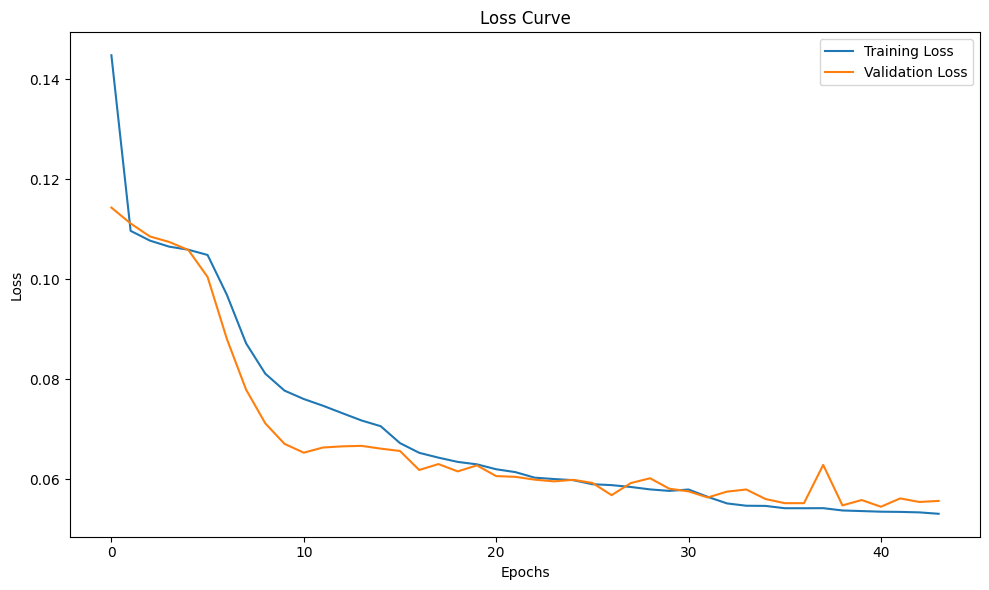

Best model selected at epoch 41 with validation loss: 0.054487


In [ ]:
## Display train / valid curves

# Plot loss curves
plt.figure(figsize=(10, 6))

# Plotting Training and Validation Loss
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best model selected at epoch {best_epoch} with validation loss: {best_valid_loss:.6f}")


---
## Test the Trained Network

Test Loss: 0.059837



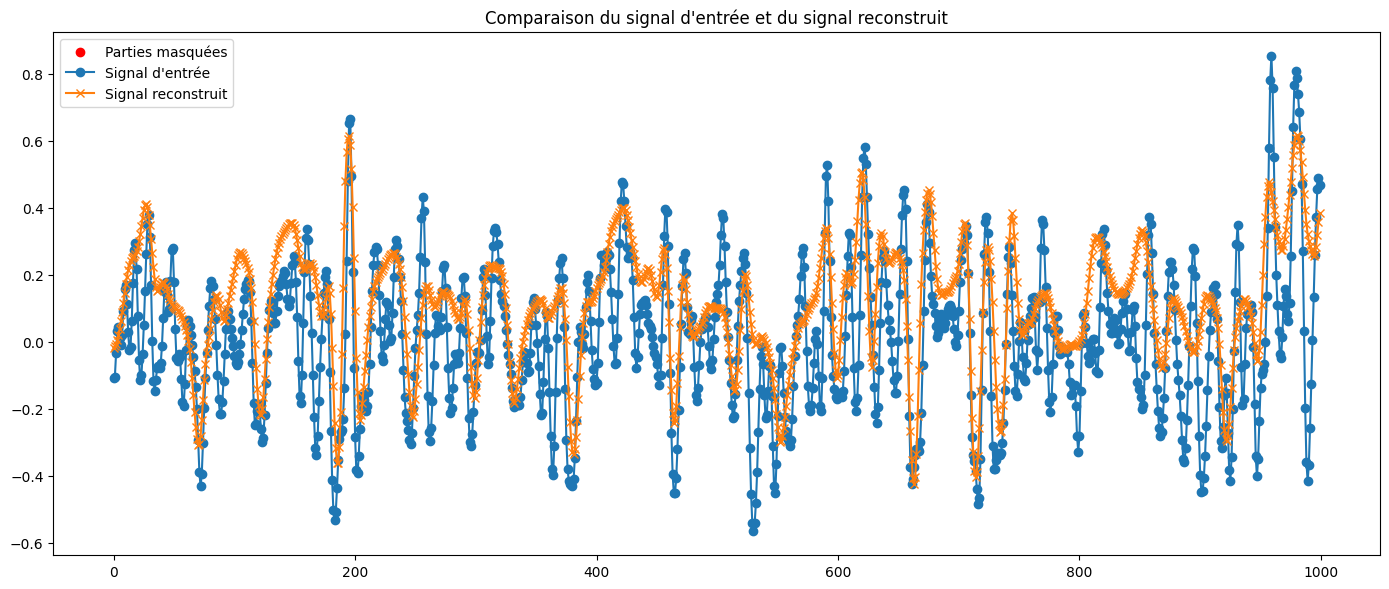

In [ ]:
# Charger le best_model enregistré
model.load_state_dict(best_model)
model.eval()  # Préparer le modèle pour l'évaluation

# Initialiser les listes pour surveiller la perte de test et la précision
test_loss = 0.0

with torch.no_grad():
    for batch_data in valid_loader:
        # Décomposer les données du batch (x_masked, mask, x_original, labels)
        x_masked, mask, x_original, labels = [item.to(device).float() for item in batch_data]

        # Assurez-vous que le masque est de type bool
        mask = mask.squeeze(1).bool()

        x_original = x_original.squeeze(1)
        
        # Forward pass: compute predicted outputs by passing inputs to the model
        output, latent_space = model(x_masked)
        
        # Calculer la perte
        loss = criterion(output, x_original)
        
        # Mettre à jour la perte de test
        test_loss += loss.item() * x_masked.size(0)

# Calculer et afficher la perte moyenne de test
test_loss = test_loss / len(valid_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

# Prendre un batch au hasard dans valid_loader
random_index_batch = np.random.randint(0, len(valid_loader.dataset))
for i, batch_data in enumerate(valid_loader):
    if i == random_index_batch:
        x_masked, mask, x_original, _ = [item.to(device).float() for item in batch_data]
        output, latent_space = model(x_masked)

# Afficher un signal d'entrée au hasard et sa reconstruction
random_index = np.random.randint(0, x_original.shape[0])
input_signal = x_original[random_index].squeeze().cpu().detach().numpy()
reconstructed_signal = output[random_index].squeeze().cpu().detach().numpy()
mask_signal = mask[random_index].cpu().detach().numpy()

plt.figure(figsize=(14, 6))

# Afficher les parties masquées en rouge
masked_indices = np.where(mask_signal[1000:2000] == 0)[0]
plt.scatter(masked_indices, input_signal[masked_indices + 1000], color='red', label='Parties masquées', zorder=3)

# Afficher le signal d'entrée et le signal reconstruit sur le même graphique
plt.plot(input_signal[1000:2000]-np.mean(input_signal), marker='o', label='Signal d\'entrée', zorder=1)
plt.plot(1.5*reconstructed_signal[1000:2000], marker='x', label='Signal reconstruit', zorder=2)

plt.title("Comparaison du signal d'entrée et du signal reconstruit")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Projection de l'espace latent avec PCA

import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA

# Initialize labels tensor
labels = torch.tensor([]).to(device)
latent_space = torch.tensor([]).to(device)

# Supposons que transformer_feat est un tenseur PyTorch, et labels est également un tenseur PyTorch
with torch.no_grad():
    for batch_data in valid_loader:
        x_masked, _, _, label = [item.to(device).float() for item in batch_data]
        labels = torch.cat((labels, label), 0)
        _, latent = model(x_masked)
        latent_space = torch.cat((latent_space, latent), 0)

# Vérification des dimensions du tenseur
latent_space = latent_space.detach().cpu()

print(f"Latent space shape: {latent_space.shape}")

if latent_space.dim() > 2:
    # Applatir les dimensions supplémentaires pour préparer les données pour PCA
    latent_space = latent_space.contiguous().view(latent_space.shape[0], -1)

# Conversion en NumPy pour PCA
latentspace = latent_space.cpu().numpy()
target_np = labels.cpu().numpy()

# Appliquer PCA pour réduire à 3 dimensions
pca = PCA(n_components=3)
pca_result = pca.fit_transform(latentspace)

# Vérification des dimensions
assert pca_result.shape[1] == 3, "PCA n'a pas réussi à réduire à 3 dimensions"

# Configuration des couleurs et des labels pour la visualisation
unique_labels = np.unique(target_np)
colors = px.colors.qualitative.Plotly  # Palette de couleurs pour chaque classe

# Créer un plot 3D interactif
fig = go.Figure()

# Ajouter des points pour chaque classe
for label, color in zip(unique_labels, colors):
    indices = np.where(target_np == label)
    fig.add_trace(go.Scatter3d(
        x=pca_result[indices, 0].flatten(),
        y=pca_result[indices, 1].flatten(),
        z=pca_result[indices, 2].flatten(),
        mode='markers',
        marker=dict(color=color),
        name=f'Class {label}'
    ))

# Ajouter des détails au graphique
fig.update_layout(
    title="PCA Projection of Transformer Output",
    scene=dict(
        xaxis_title="Principal Component 1",
        yaxis_title="Principal Component 2",
        zaxis_title="Principal Component 3"
    ),
    legend_title="Classes"
)

# Afficher le graphique
fig.show()


Latent space shape: torch.Size([100, 32, 256])


In [ ]:
from sklearn.manifold import TSNE

# Projection de l'espace latent avec t-SNE en 3D

# Appliquer t-SNE pour réduire à 3 dimensions
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(latentspace)

# Vérification des dimensions
assert tsne_result.shape[1] == 3, "t-SNE n'a pas réussi à réduire à 3 dimensions"

# Configuration des couleurs et des labels pour la visualisation
unique_labels = np.unique(target_np)
colors = px.colors.qualitative.Plotly  # Palette de couleurs pour chaque classe

# Créer un plot 3D interactif
fig = go.Figure()

# Ajouter des points pour chaque classe
for label, color in zip(unique_labels, colors):
    indices = np.where(target_np == label)
    fig.add_trace(go.Scatter3d(
        x=tsne_result[indices, 0].flatten(),
        y=tsne_result[indices, 1].flatten(),
        z=tsne_result[indices, 2].flatten(),
        mode='markers',
        marker=dict(color=color),
        name=f'Class {label}'
    ))

# Ajouter des détails au graphique
fig.update_layout(
    title="t-SNE Projection of Transformer Output",
    scene=dict(
        xaxis_title="Component 1",
        yaxis_title="Component 2",
        zaxis_title="Component 3"
    ),
    legend_title="Classes"
)

# Afficher le graphique
fig.show()
